In [1]:
#James Daus and Matthew Chistolini 4/22/19-5/2/19
#Work length: 15 hours each

import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import datetime
import random

def whatSymMeans():
    '''
    () -> list
    this function takes a file of all publicly traded stocks on the stock 
    market as of 2019 April and outputs a list with just the symbols
    '''
    infile = open('500.txt','r')
    infile.readline()
    symbolList =[]
    for line in infile:
        symbolList += [line.strip()]
    return symbolList

def allSymbols():
    '''
    () -> list
    this function takes a file of all publicly traded stocks on the stock 
    market as of 2019 April and outputs a list with just the symbols
    '''
    infile = open('acceptedList.txt','r')
    infile.readline()
    symbolList =[]
    for line in infile:
        sym = line.split()
        symbolList +=[sym[0]]
    return symbolList

def checkifvalidstock(userstock):
    '''
    (string) -> bool
    this function takes a stock symbol and outputs if it is a vaild 
    US stock and has data for at least one previous year and one future year
    '''
    if userstock in allSymbols():
        return True
    else:
        return False

def chartStock(stockData,sym):
    '''
    (list, str) -> plot
    creates plot from the list of data
    '''
    stockData = pd.Series(stockData)
    stockData.plot()
    plt.title('Last Years Preforance of '+str(sym))
    plt.ylabel('price in dollars($)')
    plt.xlabel('days since last January')
    plt.show() 

def readCSV(sym,timeFrame):
    '''
    (str, str) -> pd list
    Reads CSV file based on input vars and returns panda data
    '''
    if timeFrame.upper() == 'D':
        data = pd.read_csv(str(sym)+ ".csv",index_col=0)
    elif timeFrame.upper() == 'M':
        data = pd.read_csv(str(sym)+ "MONTH.csv",index_col=0)
    return data

def indexForbeginningOfPeroid(typeMD,year):
    if typeMD.upper() == 'D':
        yearIndex = [506, 758, 1006 ,1258,1510,1762,2014,2265,2516,2769,3021 ,3273 ,3525 ,3775,4027 ,4279 ,4531,4783, 5034,5285]
    elif typeMD.upper() == 'M':
        yearIndex = [25,37,49,61,73,85,97,109,121,133,145,157,169,181,193, 205,217,229,241,253]
    year -=2000
    return yearIndex[year]

def openStock(sym,year,lengthOfTime = None,timeUnit = 'D'):
    '''
    (str, int) -> pd list
    returns stock info for company and year
    if there is no length of time selected it will just return the spot price for that day
    '''
    if timeUnit.upper() == 'D':
        symDF=readCSV(sym,'D')
        startIndix=indexForbeginningOfPeroid('D',year)
        return openData(symDF,startIndix,lengthOfTime)
    elif timeUnit.upper() == 'M':
        symDF=readCSV(sym,'M')
        startIndix=indexForbeginningOfPeroid('M',year)
        return openData(symDF,startIndix,lengthOfTime)
    
def openData(symDF,startIndix,lengthOfTime):
    if lengthOfTime==None:
        return symDF.iloc[startIndix,:]['1. open']
    openPrices=[]
    for i in range(abs(lengthOfTime)):
        if lengthOfTime>0:
            openPrices+=[symDF.iloc[startIndix+i,:]['1. open']]
        else:
            openPrices=[symDF.iloc[startIndix-i,:]['1. open']]+openPrices
    return openPrices

def perchange(series):
    perchangelist = []
    for i in range(len(series)-1):
        perchangelist.append((series[i+1]-series[i])/series[i])
    return perchangelist

def beta(symbol,year):
    '''
    (str,int) -> float
    calculates and returns beta value for stock during year
    '''
    symbol = openStock(symbol,year,-36,'M')
    index = openStock('SPY',year,-36,'M')
    index = perchange(index)
    symbol = perchange(symbol)
    index = pd.Series(index)
    symbol = pd.Series(symbol)
    covar = symbol.cov(index)
    var = index.var()
    beta = covar/var
    return beta

def lastYearReturn(symbol,year):
    '''
    (str,int) -> float
    returns stock price from prior year
    '''
    currentPrice = openStock(symbol,year)
    lastYearPrice  = openStock(symbol,year-1)
    return (currentPrice-lastYearPrice)/lastYearPrice

def alpha(sym, year):
    '''
    (str, int) -> float
    calculates and returns alpha value for stock during year
    '''
    lY =lastYearReturn(sym,year)
    rF = riskfree(year)/100
    mK = lastYearReturn('SPY',year)
    b = beta(sym,year)
    alpha = (lY - (rF+(mK-lY)*b))*10
    return alpha
    
def riskfree(year):
    year-=2000
    tbill = [6.11, 3.49, 2.00,1.24,1.89,3.62,4.94,4.53,1.83,0.47,0.32,0.18,0.17,0.13,0.12,0.32,0.61,1.19,2.33,2.52]
    return tbill[year]

def round_down(n,places):
    '''
    (float,int) -> float
    Takes a number and a value of decimal places then truncates to that value
    '''
    multiplier= 10 ** places
    return math.floor(n*multiplier)/multiplier


In [2]:
## User input python

def printAllAvaliableStocks():
    '''
    () -> print
    Displays all stocks currently in game
    '''
    stockDeffintions = whatSymMeans()
    for stock in allSymbols():
        print('Enter',stock, 'for ', end='')
        for i in stockDeffintions:
            sym = i.split(",")
            if stock == sym[0]:
                print(sym[1],end='')
        print()

def stockSelection(year):
    '''
    (int) -> dict
    Runs main game UI
    '''
    printAllAvaliableStocks()
    userStockDict = {}
    money = 10000
    done = False
    while not done:
        print('\nBank Account Balance:', round(money,2))
        print('Stocks in portfolio:',','.join(userStockDict.keys()))
        userStock = input('Select a stock to examine! (Leave blank when done): ')
        userStock = userStock.upper()
        if userStock == '':
            return userStockDict
        if checkifvalidstock(userStock):
            chartStock(openStock(userStock,year,-365),userStock)
            cost = openStock(userStock,year)
            highstNumStock = round_down(money/cost,0)
            print('At', cost, 'you could by at most:',highstNumStock,'stocks.')
            numberOfStock = input('How much would you like to buy? ')
            if numberOfStock.isnumeric():
                numberOfStock = float(numberOfStock)
                if numberOfStock*cost<=money:
                    userStockDict[userStock] = userStockDict.get(userStock,0) + numberOfStock
                    money -= numberOfStock*cost
                else:
                    print('You are way too poor to buy that many shares of',userStock)
                if money<=0:
                    print("You're broke! Trading over.")
                    return userStockDict
            else:
                print('An integer please!')
        else:
            print('Invalid stock symbol. Transaction cancelled.')
            
def inAYear(year,portfolio):
    '''
    (int, dict) -> float
    calculates and returns final value of portfolio
    '''
    money = 0
    for key in portfolio: 
        money+=openStock(key,year+1)*portfolio[key]
    return money

def setyear():
    '''
    () -> int
    selects random year for game round
    '''
    year = random.randint(2004,2018)
    print('The date is January 1st, ',year,". We will check back in one year's time. Choose some stocks!\n",sep='' )
    return year

In [3]:
from sklearn.svm import SVR

def Sherstock(year):
    '''
    (int) -> dict
    Creates and teaches AI from past information to choose future stocks. Returns AI's predicted best portfolio.
    '''
    print('\nProcessing...\n')
    highestval=0
    yearspan=list(range(2001,year))
    X_train=np.reshape(yearspan,(len(yearspan),1))
    y_train=[]
    
    Sherstock_Lin = SVR(kernel= 'linear', C=1e3) #Creates Linear Machine Learning Model (tested more effective than RBF, Poly, and homemade Decision Tree)
    
    for sym in allSymbols():
        for i in range(2001,year):
            y_train.append([alpha(sym,i)]) #Construct Training Data
        Sherstock_Lin.fit(X_train,np.ravel(y_train))
        prediction=Sherstock_Lin.predict([[year]])
        y_train=[] #Reset training data
        if prediction>highestval: #Updates Sherstock pick
            highestval=prediction
            bestsym=sym
            
    print('Our highly intelligent AI has chosen the stock:',bestsym)
    print('It has purchased',10000//openStock(bestsym,year),'shares\n')
    return {bestsym:10000//openStock(bestsym,year)}

Welcome to a Stock Trading Bananza. Can you beat Sherstock the AI in a 1-year stock duel?
The date is January 1st, 2016. We will check back in one year's time. Choose some stocks!

Enter AOS for A.O. Smith Corp
Enter ABT for Abbott Laboratories
Enter FITB for Fifth Third Bancorp
Enter AZO for AutoZone Inc
Enter TXT for Textron Inc.
Enter SNA for Snap-On Inc.
Enter M for Macy's Inc.
Enter UHS for "Universal Health Services
Enter AMZN for Amazon.com Inc.
Enter UDR for UDR Inc
Enter CDNS for Cadence Design Systems
Enter TTWO for Take-Two Interactive
Enter PX for Praxair Inc.
Enter SBUX for Starbucks Corp.
Enter SCHW for Charles Schwab Corporation
Enter XEL for Xcel Energy Inc
Enter AAPL for Apple Inc.
Enter WMT for Wal-Mart Stores

Bank Account Balance: 10000
Stocks in portfolio: 
Select a stock to examine! (Leave blank when done): WMT


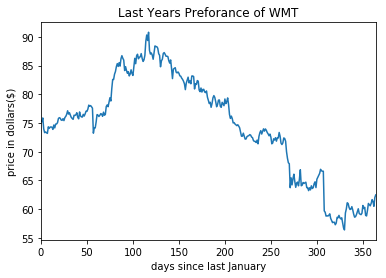

At 62.48 you could by at most: 160.0 stocks.
How much would you like to buy? 20

Bank Account Balance: 8750.4
Stocks in portfolio: WMT
Select a stock to examine! (Leave blank when done): three
Invalid stock symbol. Transaction cancelled.

Bank Account Balance: 8750.4
Stocks in portfolio: WMT
Select a stock to examine! (Leave blank when done): AMZN


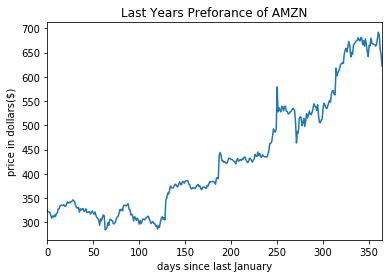

At 622.0 you could by at most: 14.0 stocks.
How much would you like to buy? four
An integer please!

Bank Account Balance: 8750.4
Stocks in portfolio: WMT
Select a stock to examine! (Leave blank when done): AMZN


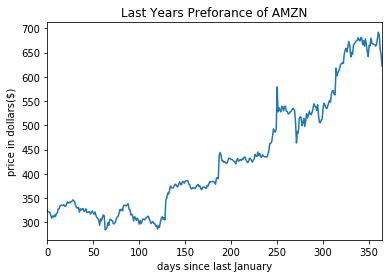

At 622.0 you could by at most: 14.0 stocks.
How much would you like to buy? 14

Bank Account Balance: 42.4
Stocks in portfolio: WMT,AMZN
Select a stock to examine! (Leave blank when done): aapl


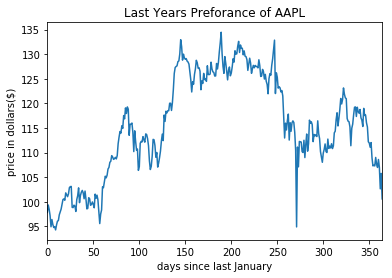

At 100.56 you could by at most: 0.0 stocks.
How much would you like to buy? 
An integer please!

Bank Account Balance: 42.4
Stocks in portfolio: WMT,AMZN
Select a stock to examine! (Leave blank when done): 

Processing...

Our highly intelligent AI has chosen the stock: AMZN
It has purchased 16.0 shares

In one year your stocks will be worth: 12030.3
In one year Sherstock's stocks will be worth: 12184.8

Our machine is more powerful! Better luck next time... if there is a next time
Reload to play again!


In [4]:
def main():
    print('Welcome to a Stock Trading Bananza. Can you beat Sherstock the AI in a 1-year stock duel?')
    year = setyear()
    portfolio = stockSelection(year) #Creates dictonary of chosen symbols and # of shares
    user_results = inAYear(year,portfolio) 
    AI_results = inAYear(year,Sherstock(year))
    print('In one year your stocks will be worth:',round(user_results,3))
    print("In one year Sherstock's stocks will be worth:",round(AI_results,3))
    if user_results>AI_results: #Checks results
        print("\nYou've defeated the AI! For now...")
    elif user_results==AI_results:
        print("A... tie!? Are you... a robot!?")
    else:
        print("\nOur machine is more powerful! Better luck next time... if there is a next time")
    print('Reload to play again!')
main()